In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
df = pd.read_csv("data/data.csv")

In [3]:
df = df[:50]
df = df.loc[:, :' Cash flow rate']

In [4]:
dataset_knn = df.copy()
df.head()

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,1.078888e-04,0.0,0.465705
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,7.890000e+09,0.0,0.462746


<Axes: >

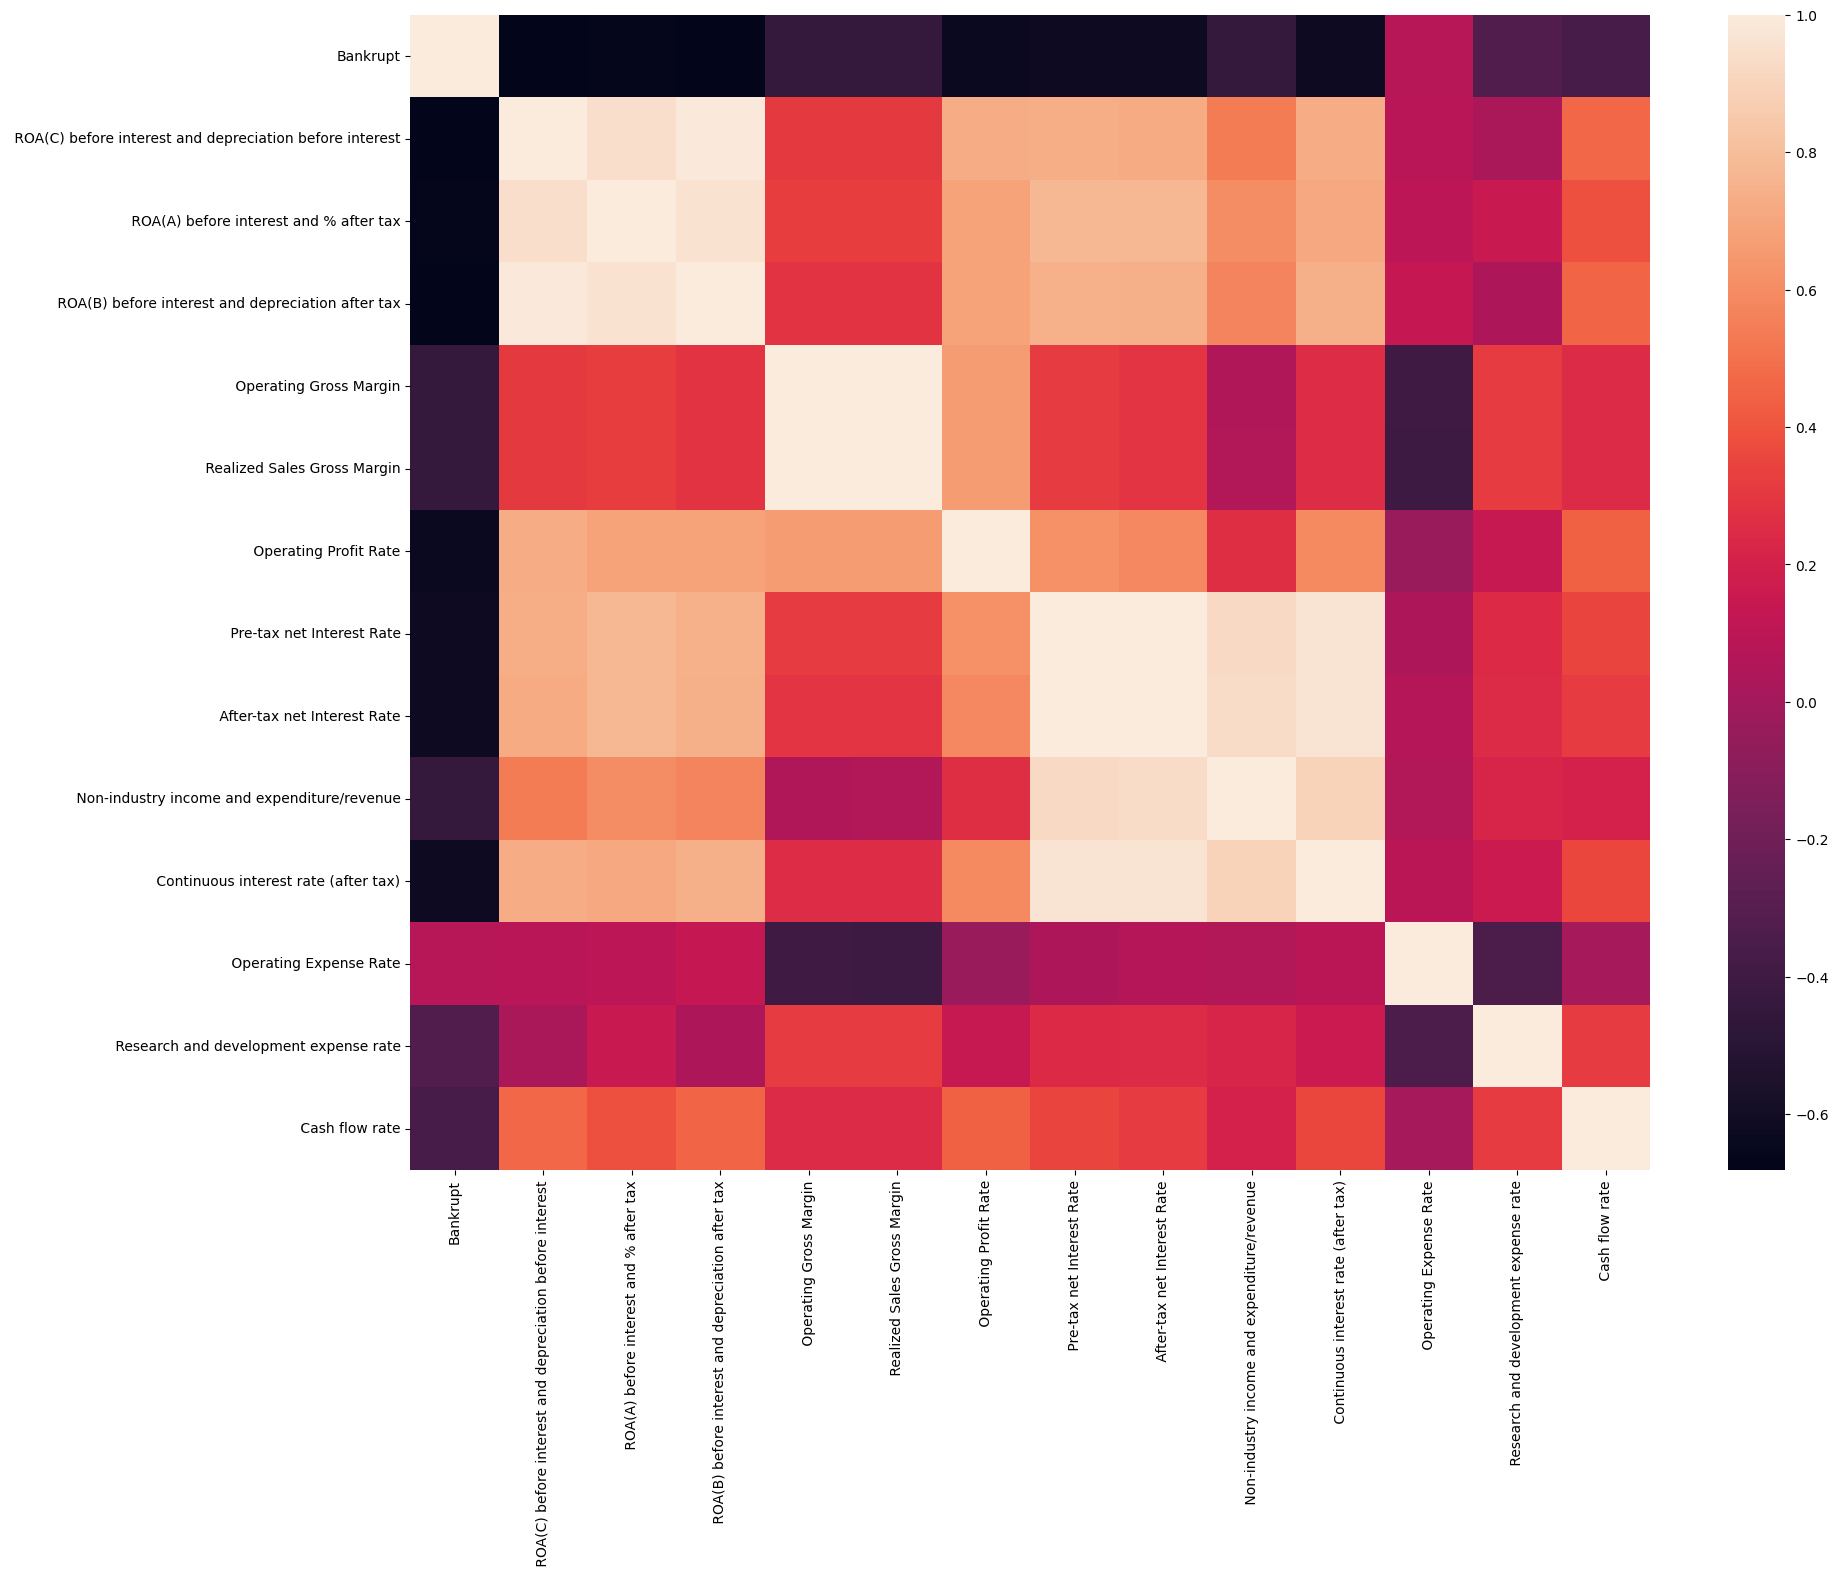

In [5]:
plt.subplots(figsize=(20,15))
sn.heatmap(df.corr())

In [6]:
dataset_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  50 non-null     int64  
 1    ROA(C) before interest and depreciation before interest  50 non-null     float64
 2    ROA(A) before interest and % after tax                   50 non-null     float64
 3    ROA(B) before interest and depreciation after tax        50 non-null     float64
 4    Operating Gross Margin                                   50 non-null     float64
 5    Realized Sales Gross Margin                              50 non-null     float64
 6    Operating Profit Rate                                    50 non-null     float64
 7    Pre-tax net Interest Rate                                50 non-null     float64
 8    After-tax net Interes

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [8]:
df_Predictors=dataset_knn.drop(["Bankrupt"],axis=1)
df_target=dataset_knn.Bankrupt
features = df_Predictors

In [9]:
Xtrain,Xtest,ytrain,ytest=train_test_split(df_Predictors,df_target,random_state=10,test_size=0.2)
print("Shape of Xtrain:{} and Shape of ytrain:{} ".format(Xtrain.shape,ytrain.shape))
print("Shape of Xtest:{} and Shape of ytest:{} ".format(Xtest.shape,ytest.shape))

Shape of Xtrain:(40, 13) and Shape of ytrain:(40,) 
Shape of Xtest:(10, 13) and Shape of ytest:(10,) 


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from scipy import stats


import time
import math 
import warnings

warnings.filterwarnings('ignore')

In [11]:
# define classifier
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    #"RandomForest" : RandomForestClassifier(random_state=42),
    #"LGBM" : LGBMClassifier(random_state=42)
}

# define grid
KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

RF_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 6, 8, 10, 12]}

LGBM_grid = {'n_estimators': [50, 100, 150],
        'max_depth': [4, 6, 8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

grid = {
    "KNN" : KNN_grid,
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : LGBM_grid
}

i=0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
                    'Classifer':classifiers.keys(),
                    'Train accuracy' : np.zeros(len(classifiers)),
                    'Validation accuracy': np.zeros(len(classifiers)),
                    'Training time': np.zeros(len(classifiers))
                    })

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(Xtrain, ytrain)
    scores.iloc[i,1]=clf.score(Xtrain, ytrain)
    scores.iloc[i,2]=clf.score(Xtest, ytest)
    clf_best_params[key]=clf.best_params_
    
    stop = time.time()
    scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i,3])
    print('')
    i+=1

    
print(clf_best_params)
print(scores)

Model: KNN
Training time (mins): 0.19

Model: LogisticRegression
Training time (mins): 0.01

{'KNN': {'n_neighbors': 5, 'p': 1}, 'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'}}
            Classifer  Train accuracy  Validation accuracy  Training time
0                 KNN           0.925                  0.9           0.19
1  LogisticRegression           0.850                  0.8           0.01


In [12]:
from sklearn.svm import SVC

In [13]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df_Predictors, df_target, train_size=0.8)
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value
svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.80
Classical SVC on the test dataset:     1.00


In [14]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import Sampler

In [15]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

In [16]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

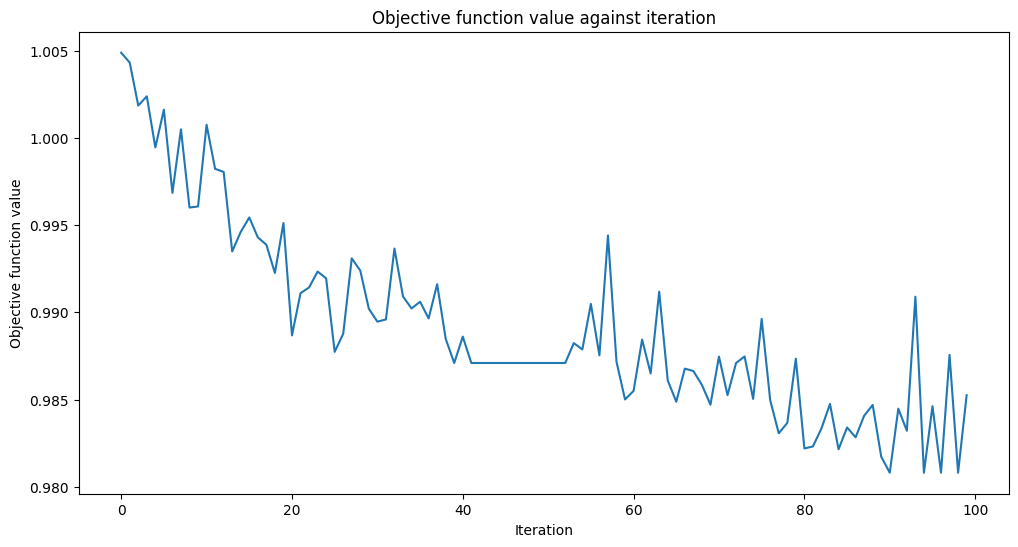

Training time: 859 seconds


In [17]:

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
train_labels = np.array(train_labels)
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.68
Quantum VQC on the test dataset using RealAmplitudes:     0.40
